In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

### Data reading

In [2]:
dataframes = []
directory = 'tennis_matches/atp'

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)
        dataframes.append(df)

# Combine all DataFrames
df_atp = pd.concat(dataframes, ignore_index=True)

In [3]:
df_atp

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2015-339,Brisbane,Hard,28,A,20150104,1,105357,NaN,WC,...,31.0,20.0,5.0,8.0,1.0,5.0,153.0,328.0,220.0,221.0
1,2015-339,Brisbane,Hard,28,A,20150104,2,103813,NaN,NaN,...,50.0,26.0,19.0,13.0,3.0,8.0,73.0,689.0,123.0,440.0
2,2015-339,Brisbane,Hard,28,A,20150104,3,105902,NaN,WC,...,37.0,22.0,5.0,8.0,10.0,15.0,125.0,430.0,21.0,1730.0
3,2015-339,Brisbane,Hard,28,A,20150104,4,104871,NaN,NaN,...,38.0,30.0,8.0,10.0,1.0,3.0,31.0,1195.0,72.0,691.0
4,2015-339,Brisbane,Hard,28,A,20150104,5,105373,NaN,NaN,...,62.0,40.0,19.0,15.0,4.0,8.0,34.0,1094.0,110.0,505.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23974,2023-M-DC-2023-WG2-PO-RSA-LUX-01,Davis Cup WG2 PO: RSA vs LUX,Hard,4,D,20230204,5,202335,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1717.0,1.0
23975,2023-M-DC-2023-WG2-PO-TUN-CYP-01,Davis Cup WG2 PO: TUN vs CYP,Hard,4,D,20230203,1,117365,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,990.0,11.0,279.0,190.0
23976,2023-M-DC-2023-WG2-PO-TUN-CYP-01,Davis Cup WG2 PO: TUN vs CYP,Hard,4,D,20230203,2,121411,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,364.0,131.0,894.0,15.0
23977,2023-M-DC-2023-WG2-PO-TUN-CYP-01,Davis Cup WG2 PO: TUN vs CYP,Hard,4,D,20230203,4,144949,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,894.0,15.0,285.0,184.0


### Data cleaning

Remove columns with more than 50% missing. Info in these columns doesn't look important.

- winner entry - 85% are empty data
- winner seed - 57% are empty data
- loser entry - 77% are empty data
- loser seed - 75% are empty data


In [4]:
df_atp.drop(columns=['winner_entry', 'winner_seed', 'loser_entry', 'loser_seed'], inplace=True)

Put 'U' (Unknown) where is no info about hand

In [5]:
df_atp.fillna(value={'winner_hand': 'U', 'loser_hand': 'U'}, inplace=True)
df_atp['loser_hand'].unique()

array(['R', 'L', 'U'], dtype=object)

Try to fill missing age

In [6]:
df_atp[df_atp['winner_age'].isna()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
14404,2019-M-DC-2019-G2-AO-M-NZL-INA-01,Davis Cup G2 R1: NZL vs INA,Hard,4,D,20190914,4,209188,Ari Fahresi,U,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,744.0,22.0
21509,2022-M-DC-2022-WG1-M-BIH-MEX-01,Davis Cup WG1 R1: BIH vs MEX,Clay,4,D,20220916,4,211468,Luis Carlos Alvarez Valdes,U,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1194.0,5.0
21588,2022-M-DC-2022-WG2-M-SLO-EST-01,Davis Cup WG2 R1: SLO vs EST,Clay,4,D,20220916,4,210753,Matic Kriznik,U,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,518.0,58.0


In [7]:
player_id = 209188
df_atp[(df_atp['winner_id'] == player_id) | (df_atp['loser_id'] == player_id)]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
14404,2019-M-DC-2019-G2-AO-M-NZL-INA-01,Davis Cup G2 R1: NZL vs INA,Hard,4,D,20190914,4,209188,Ari Fahresi,U,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,744.0,22.0


We have no enough info for filling missing age, so drop it because there are only 9 rows.

In [8]:
df_atp.dropna(subset=['winner_age', 'loser_age'], inplace=True)

In [9]:
df_atp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23970 entries, 0 to 23978
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          23970 non-null  object 
 1   tourney_name        23970 non-null  object 
 2   surface             23970 non-null  object 
 3   draw_size           23970 non-null  int64  
 4   tourney_level       23970 non-null  object 
 5   tourney_date        23970 non-null  int64  
 6   match_num           23970 non-null  int64  
 7   winner_id           23970 non-null  int64  
 8   winner_name         23970 non-null  object 
 9   winner_hand         23970 non-null  object 
 10  winner_ht           23598 non-null  float64
 11  winner_ioc          23970 non-null  object 
 12  winner_age          23970 non-null  float64
 13  loser_id            23970 non-null  int64  
 14  loser_name          23970 non-null  object 
 15  loser_hand          23970 non-null  object 
 16  loser_ht 

Try to fill missing height

In [10]:
players_missing_ht = np.concatenate((df_atp[df_atp['winner_ht'].isna()].winner_id.unique(),
                                    df_atp[df_atp['loser_ht'].isna()].loser_id.unique()))
players_missing_ht.shape

(526,)

In [11]:
df_atp[df_atp['winner_id'].isin(players_missing_ht) & df_atp['winner_ht'].notna()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points


In [12]:
df_atp[df_atp['winner_id'].isin(players_missing_ht) | df_atp['loser_id'].isin(players_missing_ht)]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
31,2015-891,Chennai,Hard,28,A,20150105,5,106210,Jiri Vesely,L,...,28.0,12.0,14.0,8.0,5.0,10.0,65.0,741.0,557.0,56.0
55,2015-451,Doha,Hard,32,A,20150105,2,104660,Sergiy Stakhovsky,R,...,23.0,11.0,3.0,7.0,3.0,8.0,57.0,781.0,NaN,NaN
527,2015-807,Acapulco,Hard,32,A,20150223,7,104678,Viktor Troicki,R,...,31.0,19.0,13.0,9.0,2.0,5.0,43.0,981.0,480.0,74.0
610,2015-D016,Davis Cup G1 R1: BAR vs DOM,Hard,4,D,20150306,1,103607,Victor Estrella,R,...,NaN,NaN,NaN,NaN,NaN,NaN,56.0,855.0,NaN,NaN
613,2015-D016,Davis Cup G1 R1: BAR vs DOM,Hard,4,D,20150306,5,105497,Jose Hernandez,U,...,NaN,NaN,NaN,NaN,NaN,NaN,268.0,182.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23973,2023-M-DC-2023-WG2-PO-RSA-LUX-01,Davis Cup WG2 PO: RSA vs LUX,Hard,4,D,20230204,4,200270,Alex Knaff,R,...,NaN,NaN,NaN,NaN,NaN,NaN,608.0,48.0,516.0,67.0
23974,2023-M-DC-2023-WG2-PO-RSA-LUX-01,Davis Cup WG2 PO: RSA vs LUX,Hard,4,D,20230204,5,202335,Raphael Calzi,U,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1717.0,1.0
23975,2023-M-DC-2023-WG2-PO-TUN-CYP-01,Davis Cup WG2 PO: TUN vs CYP,Hard,4,D,20230203,1,117365,Petros Chrysochos,R,...,NaN,NaN,NaN,NaN,NaN,NaN,990.0,11.0,279.0,190.0
23976,2023-M-DC-2023-WG2-PO-TUN-CYP-01,Davis Cup WG2 PO: TUN vs CYP,Hard,4,D,20230203,2,121411,Moez Echargui,R,...,NaN,NaN,NaN,NaN,NaN,NaN,364.0,131.0,894.0,15.0


There is no enough info to fill missing height but also there are 1k rows, so it is filled with mean value.

In [13]:
df_ht = pd.concat(
    (pd.DataFrame({'id': df_atp['winner_id'], 'ht': df_atp['winner_ht']}),
     pd.DataFrame({'id': df_atp['loser_id'], 'ht': df_atp['loser_ht']}))
)
df_ht.dropna(inplace=True)
mean_th = df_ht.groupby('id')['ht'].mean().mean()
mean_th

np.float64(185.46312684365782)

In [14]:
df_atp.fillna(value={'winner_ht': mean_th, 'loser_ht': mean_th}, inplace=True)
df_atp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23970 entries, 0 to 23978
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          23970 non-null  object 
 1   tourney_name        23970 non-null  object 
 2   surface             23970 non-null  object 
 3   draw_size           23970 non-null  int64  
 4   tourney_level       23970 non-null  object 
 5   tourney_date        23970 non-null  int64  
 6   match_num           23970 non-null  int64  
 7   winner_id           23970 non-null  int64  
 8   winner_name         23970 non-null  object 
 9   winner_hand         23970 non-null  object 
 10  winner_ht           23970 non-null  float64
 11  winner_ioc          23970 non-null  object 
 12  winner_age          23970 non-null  float64
 13  loser_id            23970 non-null  int64  
 14  loser_name          23970 non-null  object 
 15  loser_hand          23970 non-null  object 
 16  loser_ht 

Remove rows in columns where is luck of data only up to 5%.

In [15]:
columns_missing_data = ['w_ace', 'w_SvGms', 'winner_rank', 'loser_rank']

In [16]:
df_atp.dropna(subset=columns_missing_data, inplace=True)

5% of dataset were removed in total

<Axes: >

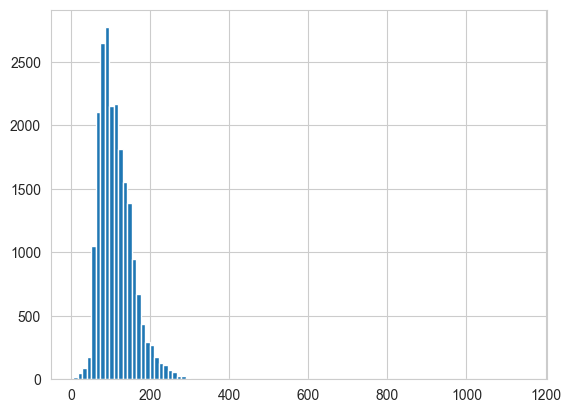

In [17]:
df_atp['minutes'].hist(bins=100)

Remove outliers

<Axes: >

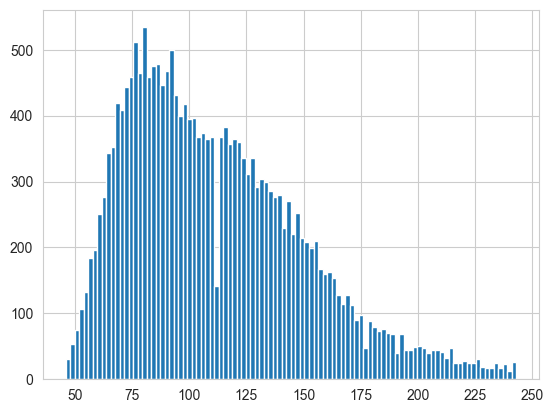

In [18]:
# Remove outliers (trim 1% from both ends)
lower_percentile, upper_percentile= 1, 99
lower = df_atp['minutes'].quantile(lower_percentile/100)
upper = df_atp['minutes'].quantile(upper_percentile/100)

df_atp = df_atp[(df_atp['minutes'] >= lower) & (df_atp['minutes'] <= upper)]
df_atp['minutes'].hist(bins=100)

Put median because the distribution is not symmetric

In [19]:
df_atp.fillna(value={'minutes': df_atp['minutes'].median()}, inplace=True)
df_atp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20799 entries, 0 to 23882
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          20799 non-null  object 
 1   tourney_name        20799 non-null  object 
 2   surface             20799 non-null  object 
 3   draw_size           20799 non-null  int64  
 4   tourney_level       20799 non-null  object 
 5   tourney_date        20799 non-null  int64  
 6   match_num           20799 non-null  int64  
 7   winner_id           20799 non-null  int64  
 8   winner_name         20799 non-null  object 
 9   winner_hand         20799 non-null  object 
 10  winner_ht           20799 non-null  float64
 11  winner_ioc          20799 non-null  object 
 12  winner_age          20799 non-null  float64
 13  loser_id            20799 non-null  int64  
 14  loser_name          20799 non-null  object 
 15  loser_hand          20799 non-null  object 
 16  loser_ht 

### Data transformation

In [20]:
df_atp['tourney_date'] = pd.to_datetime(df_atp['tourney_date'], format='%Y%m%d')
df_atp['tourney_date']

0       2015-01-04
1       2015-01-04
2       2015-01-04
3       2015-01-04
4       2015-01-04
           ...    
23878   2023-08-28
23879   2023-08-28
23880   2023-08-28
23881   2023-08-28
23882   2023-08-28
Name: tourney_date, Length: 20799, dtype: datetime64[ns]

In [21]:
df_atp['month'] = df_atp['tourney_date'].dt.month

### EDA

What's the tournament properties? What's the difference between them?

- surface
- draw size
- tourney level
- month/season

In [22]:
print('Surfaces: ' + str(df_atp['surface'].unique()))
print('Draw size: ' + str(np.sort(df_atp['draw_size'].unique())))
print('Tourney level: ' + str(df_atp['tourney_level'].unique()))
print('Month: ' + str(df_atp['tourney_date'].dt.month.unique()))

Surfaces: ['Hard' 'Clay' 'Grass' 'Carpet']
Draw size: [  2   4   8  12  16  18  24  28  32  48  56  64  96 128]
Tourney level: ['A' 'G' 'M' 'F' 'D']
Month: [ 1  2  3  4  5  6  7  8 10 11  9 12]


Does one tourney have only one surface? (Yes, it does)

In [23]:
df_atp.groupby('tourney_id')['surface'].nunique()

tourney_id
2015-1536    1
2015-2276    1
2015-301     1
2015-308     1
2015-321     1
            ..
2023-8994    1
2023-8996    1
2023-8998    1
2023-9158    1
2023-9900    1
Name: surface, Length: 836, dtype: int64

In [24]:
tourney_level_counts = df_atp.groupby('tourney_level')['tourney_id'].nunique().sort_values()
print(tourney_level_counts)

tourney_level
F     11
G     35
M     70
D    304
A    416
Name: tourney_id, dtype: int64


In [25]:
surface_counts = df_atp.groupby('surface')['tourney_id'].nunique().sort_values()
print(surface_counts)

surface
Carpet      5
Grass      64
Clay      266
Hard      501
Name: tourney_id, dtype: int64


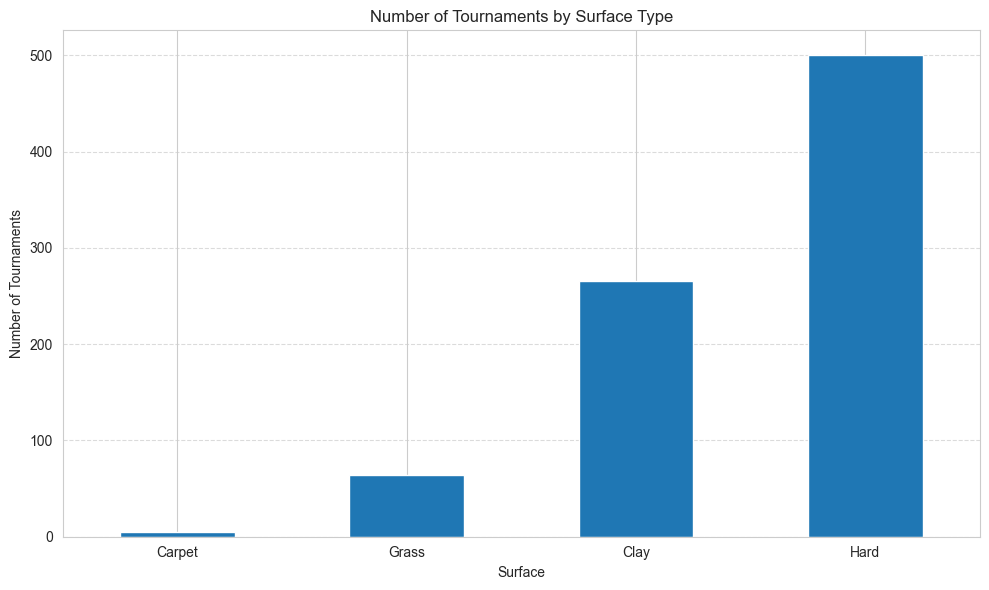

In [26]:
plt.figure(figsize=(10,6))
surface_counts.plot(kind='bar')
plt.title('Number of Tournaments by Surface Type')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylabel('Number of Tournaments')
plt.xticks(rotation=0)
plt.xlabel('Surface')
plt.tight_layout()
plt.show()

There is no enough tourneys with carpet surface.

In [27]:
df_grass = df_atp[df_atp['surface'] == 'Grass']
df_clay = df_atp[df_atp['surface'] == 'Clay']
df_hard = df_atp[df_atp['surface'] == 'Hard']

<Figure size 1500x500 with 0 Axes>

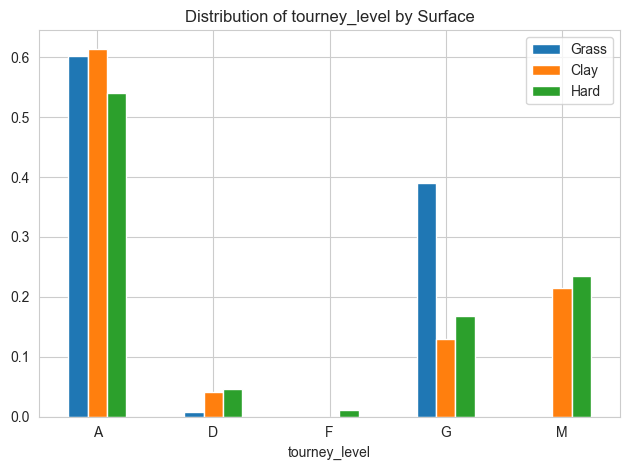

<Figure size 1500x500 with 0 Axes>

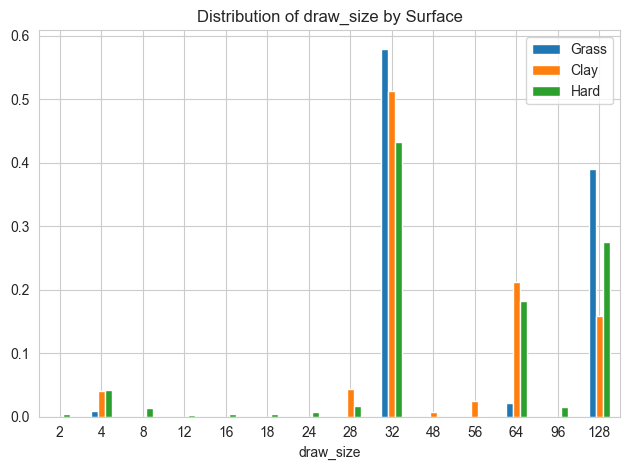

<Figure size 1500x500 with 0 Axes>

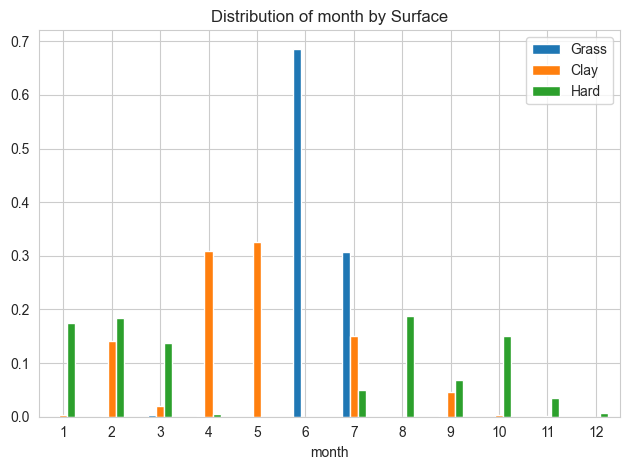

In [28]:
def categorical_comparison(column):
    plt.figure(figsize=(15,5))
    surface_cnt = [
        df_grass[column].value_counts(normalize=True),
        df_clay[column].value_counts(normalize=True),
        df_hard[column].value_counts(normalize=True)
    ]

    # Convert to DataFrame and sort the index
    df_plot = pd.DataFrame(surface_cnt).T
    df_plot = df_plot.sort_index()

    df_plot.plot(kind='bar')
    plt.title(f'Distribution of {column} by Surface')
    plt.legend(['Grass', 'Clay', 'Hard'])
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

cat_columns = ['tourney_level', 'draw_size', 'month']

for col in cat_columns:
    categorical_comparison(col)

We can see that changing one property of tourney we also chang others

### EDA of targets

#### Games features

In [29]:
game_targets = ['w_ace', 'l_ace', 'w_df', 'l_df', 'w_svpt', 'l_svpt',
           'w_1stIn', 'l_1stIn', 'w_1stWon', 'l_1stWon',
           'w_2ndWon', 'l_2ndWon', 'w_SvGms', 'l_SvGms',
           'w_bpSaved', 'l_bpSaved', 'w_bpFaced', 'l_bpFaced', 'minutes']

# Separate winner and loser columns
winner_cols = [col for col in game_targets if col.startswith('w_')]
loser_cols = [col for col in game_targets if col.startswith('l_')]

# Rename columns to remove 'w_' and 'l_' prefixes
rename_dict = {
    col: col[2:] for col in winner_cols + loser_cols
}
rename_dict['minutes'] = 'minutes'
rename_dict['surface'] = 'surface'
rename_dict['tourney_level'] = 'tourney_level'

# Process winner columns
winner_cols.extend(('minutes', 'surface', 'tourney_level'))
winner_df = df_atp[winner_cols].copy()
winner_df.columns = [rename_dict.get(col, col) for col in winner_df.columns]

# Process loser columns
loser_cols.extend(('minutes', 'surface', 'tourney_level'))
loser_df = df_atp[loser_cols].copy()
loser_df.columns = [rename_dict.get(col, col) for col in loser_df.columns]

# Combine the dataframes
df_targets = pd.concat([
    winner_df.reset_index(drop=True),
    loser_df.reset_index(drop=True)
])

In [30]:
combined_targets = ['ace', 'df', 'svpt', '1stIn', '1stWon',
                    '2ndWon', 'SvGms', 'bpSaved', 'bpFaced', 'minutes']

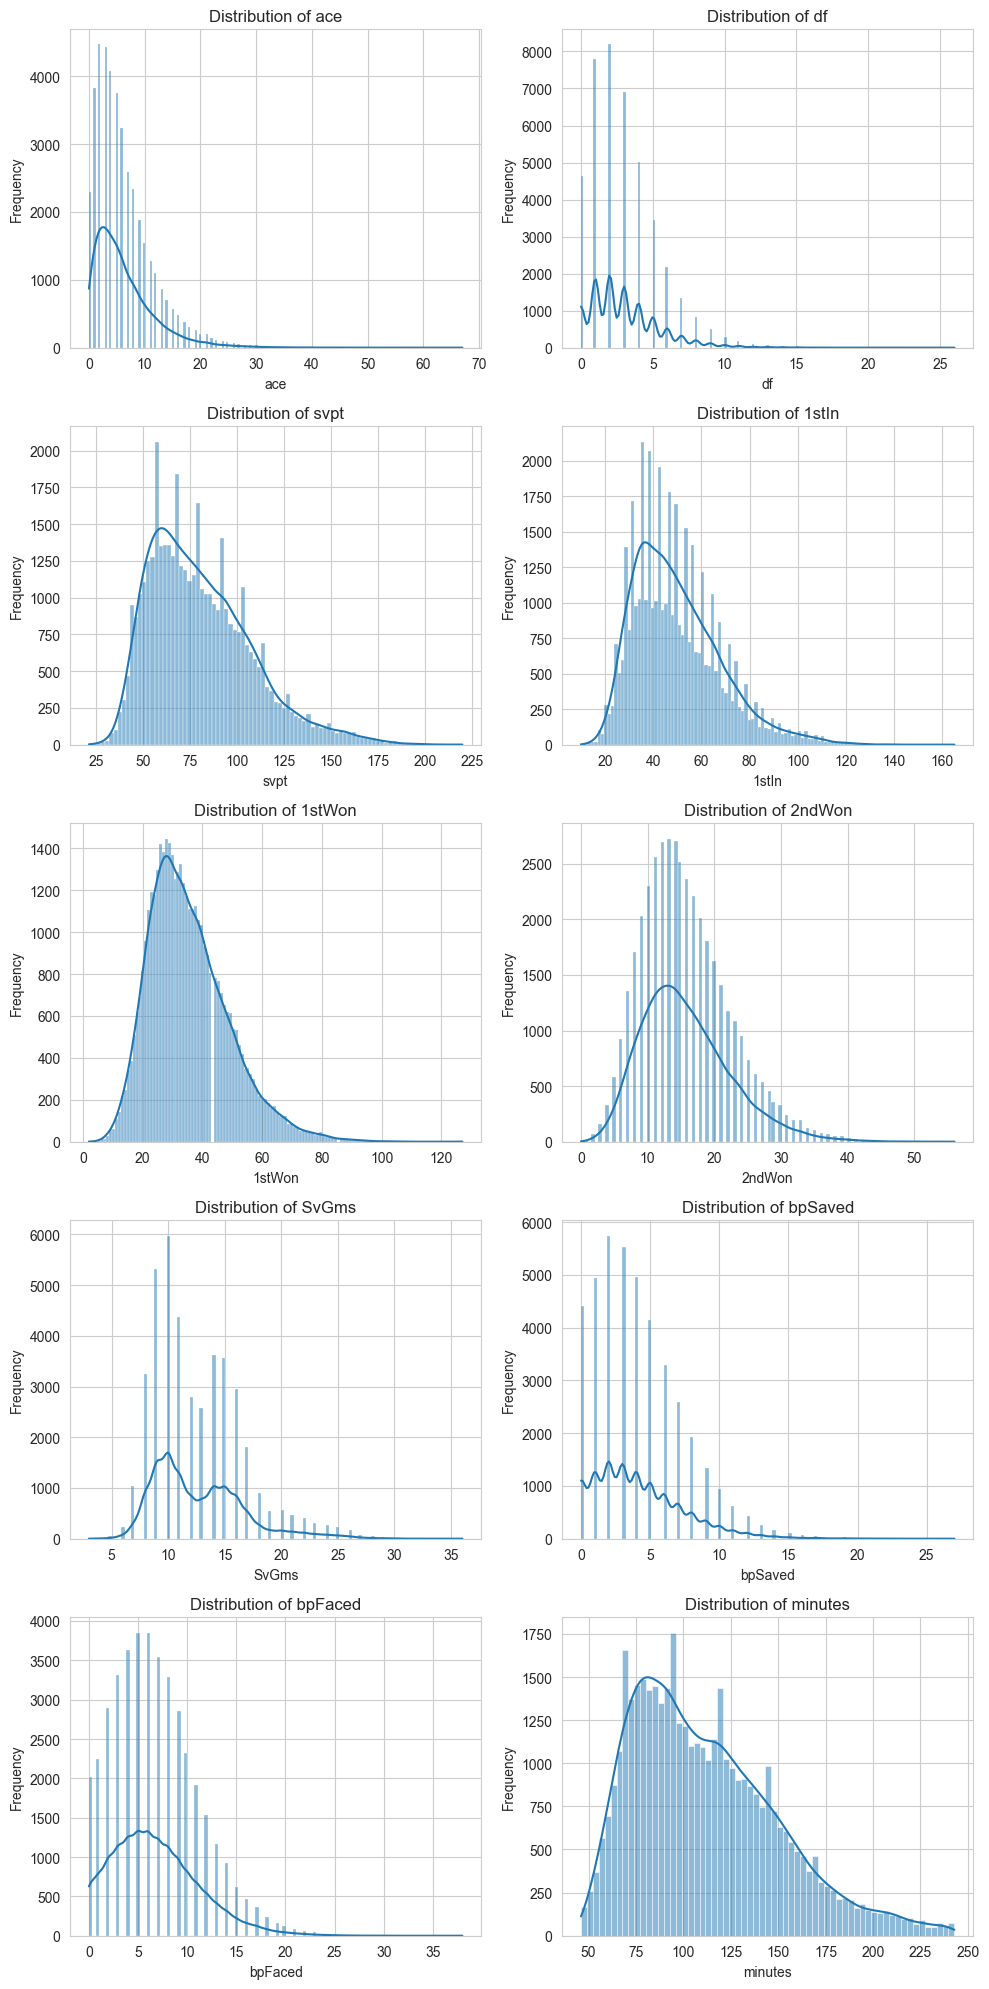

In [31]:
# Calculate the number of rows and columns for subplots
n_targets = len(combined_targets)
n_cols = 2
n_rows = (n_targets + n_cols - 1) // n_cols
plt.figure(figsize=(5*n_cols, 4*n_rows))

# Plot distribution for each target column
for i, col in enumerate(combined_targets, 1):
    plt.subplot(n_rows, n_cols, i)

    sns.histplot(df_targets[col], kde=True)

    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

ANOVA for different surfaces

In [32]:
df_anova = df_targets[df_targets['surface'] != 'Carpet']
df_anova['surface'].unique()

array(['Hard', 'Clay', 'Grass'], dtype=object)

ANOVA Analysis Results:
         F-statistic        p-value  Significant
ace      1582.176212   0.000000e+00         True
1stWon    575.693221  2.395351e-247         True
SvGms     471.791192  2.480087e-203         True
1stIn     311.154140  7.395088e-135         True
svpt      278.598400  6.455774e-121         True
df        213.821727   4.100056e-93         True
2ndWon    209.447056   3.115559e-91         True
bpFaced   119.680933   1.486955e-52         True
bpSaved    54.784705   1.732230e-24         True
minutes    44.678389   4.142346e-20         True

Features with statistically significant differences across surfaces:


<Figure size 1000x600 with 0 Axes>

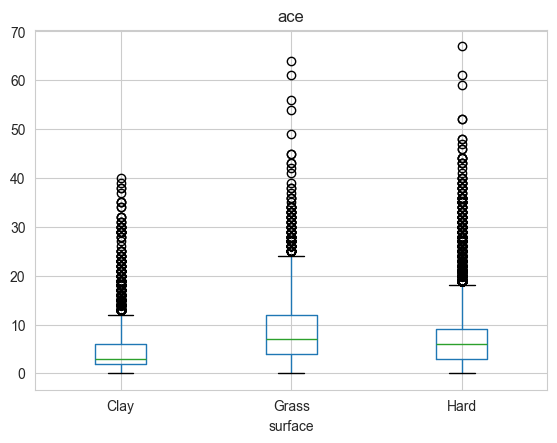

<Figure size 1000x600 with 0 Axes>

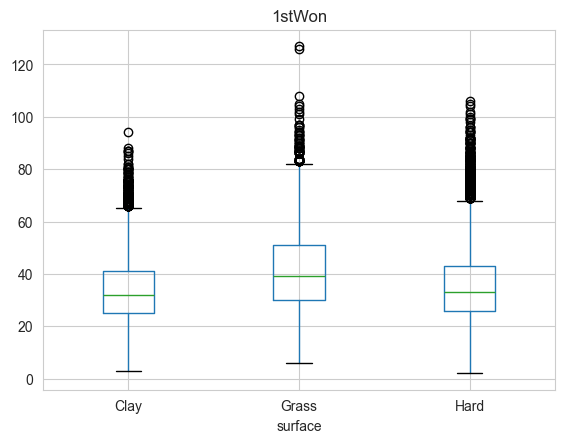

<Figure size 1000x600 with 0 Axes>

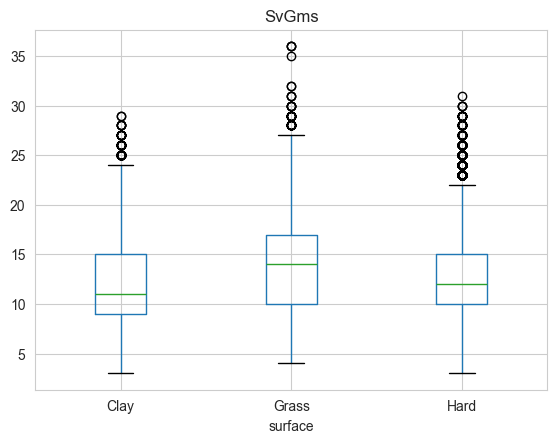

<Figure size 1000x600 with 0 Axes>

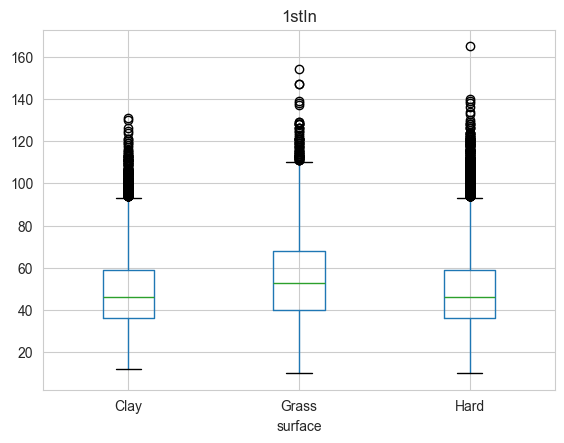

<Figure size 1000x600 with 0 Axes>

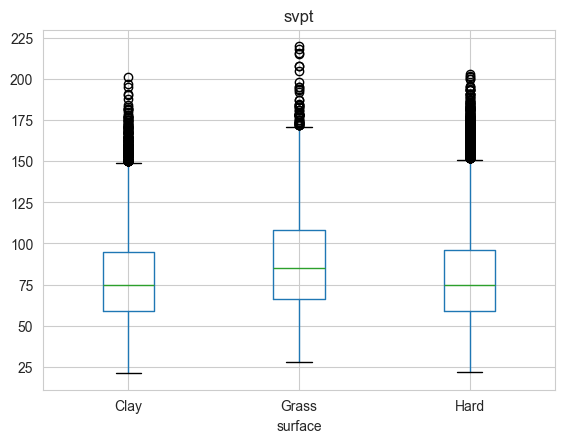

<Figure size 1000x600 with 0 Axes>

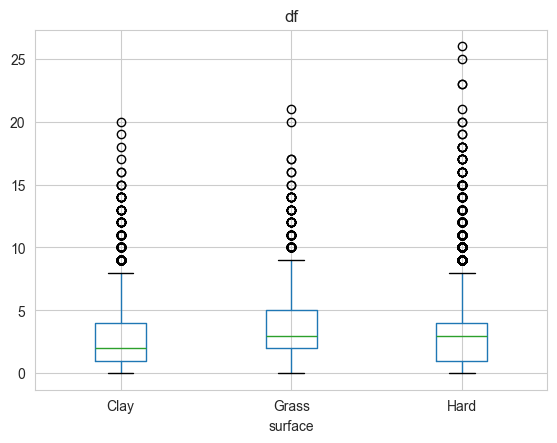

<Figure size 1000x600 with 0 Axes>

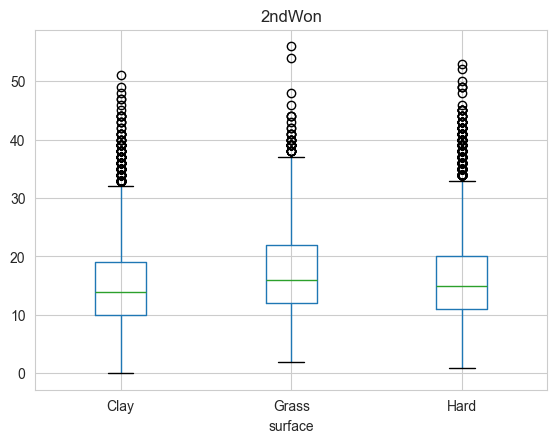

<Figure size 1000x600 with 0 Axes>

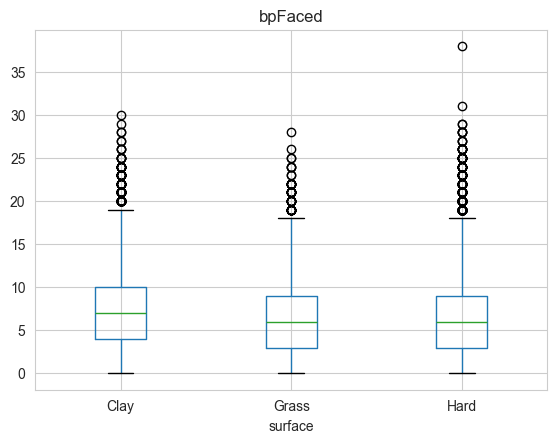

<Figure size 1000x600 with 0 Axes>

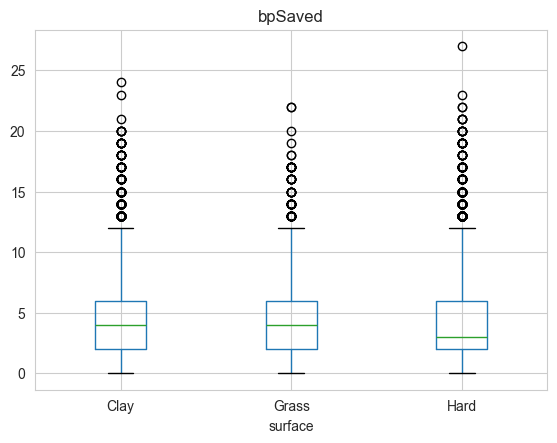

<Figure size 1000x600 with 0 Axes>

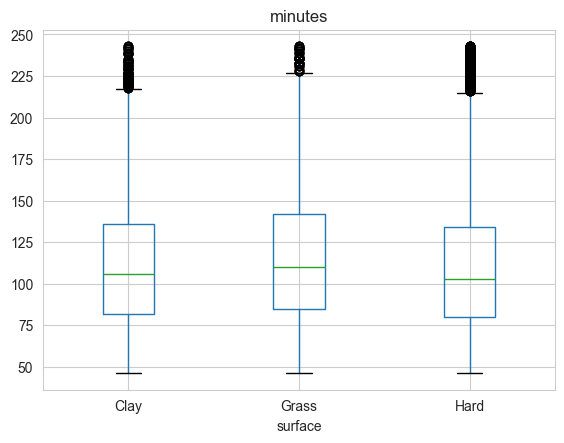

In [33]:
anova_results = {}

# Perform one-way ANOVA for each feature
for feature in combined_targets:
    grass_data = df_anova[df_anova['surface'] == 'Grass'][feature]
    clay_data = df_anova[df_anova['surface'] == 'Clay'][feature]
    hard_data = df_anova[df_anova['surface'] == 'Hard'][feature]

    f_statistic, p_value = stats.f_oneway(grass_data, clay_data, hard_data)

    anova_results[feature] = {
        'F-statistic': f_statistic,
        'p-value': p_value,
        'Significant': p_value < 0.001
    }

results_df = pd.DataFrame.from_dict(anova_results, orient='index')
results_df = results_df.sort_values('p-value')

print("ANOVA Analysis Results:")
print(results_df)

# Visualize significant differences
significant_features = results_df[results_df['Significant']].index.tolist()
if significant_features:
    print("\nFeatures with statistically significant differences across surfaces:")
    for feature in significant_features:
        plt.figure(figsize=(10,6))
        df_anova.boxplot(column=feature, by='surface')
        plt.title(f'{feature}')
        plt.suptitle('')
        plt.show()

ANOVA Analysis Results:
         F-statistic  p-value  Significant
ace       606.625432      0.0         True
df        527.813517      0.0         True
svpt     3650.683820      0.0         True
1stIn    3204.749727      0.0         True
1stWon   2935.921028      0.0         True
2ndWon   1915.571347      0.0         True
SvGms    5118.229567      0.0         True
bpSaved   528.345815      0.0         True
bpFaced   808.221902      0.0         True
minutes  2857.696170      0.0         True

Features with statistically significant differences across surfaces:


<Figure size 1000x600 with 0 Axes>

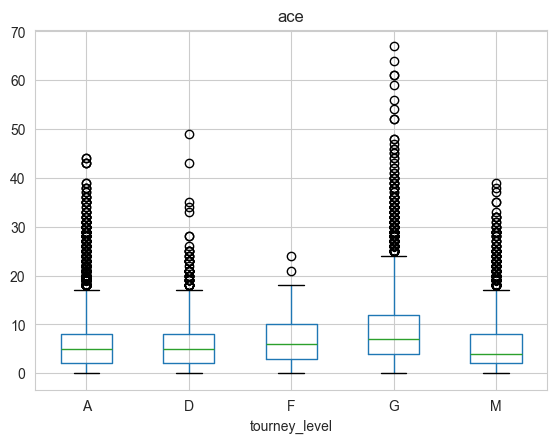

<Figure size 1000x600 with 0 Axes>

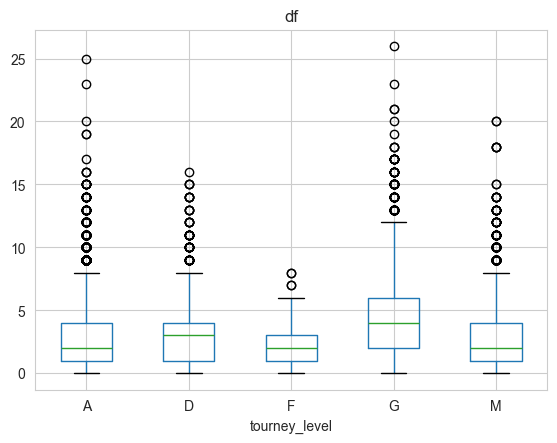

<Figure size 1000x600 with 0 Axes>

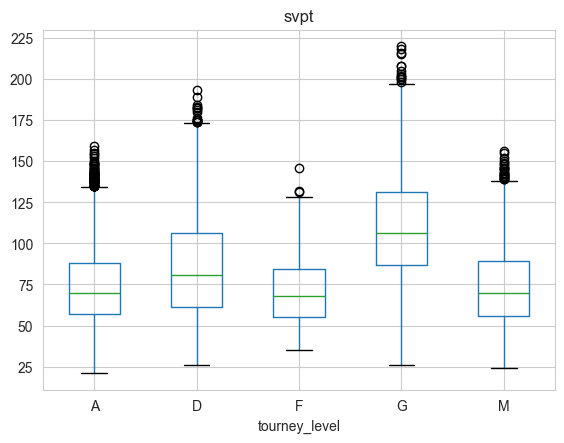

<Figure size 1000x600 with 0 Axes>

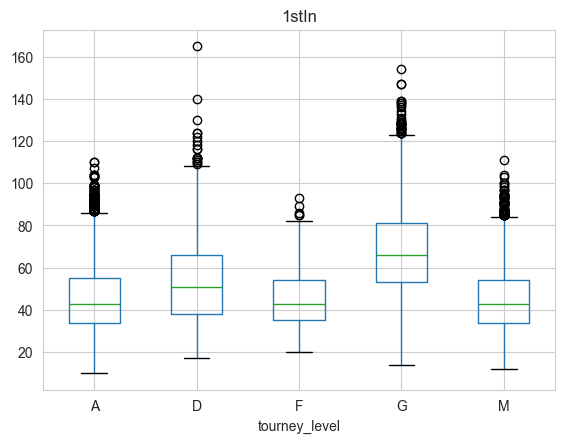

<Figure size 1000x600 with 0 Axes>

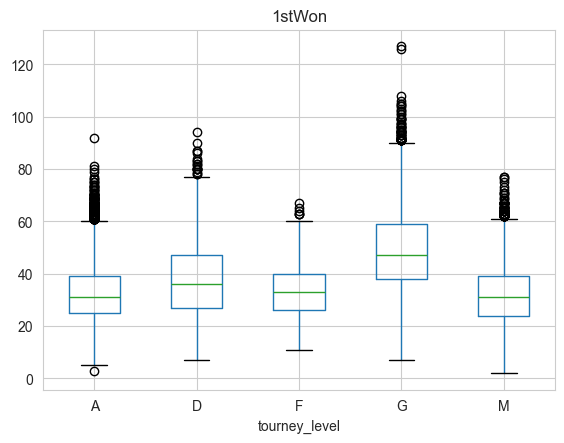

<Figure size 1000x600 with 0 Axes>

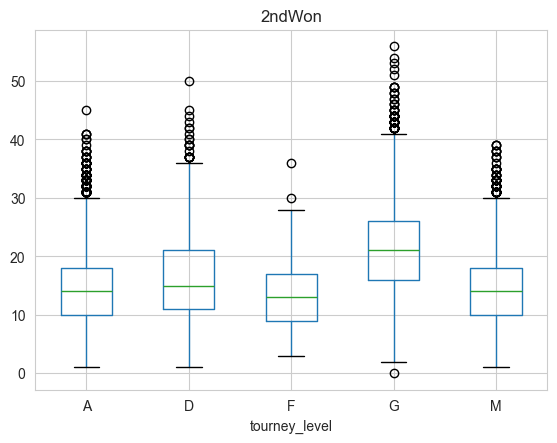

<Figure size 1000x600 with 0 Axes>

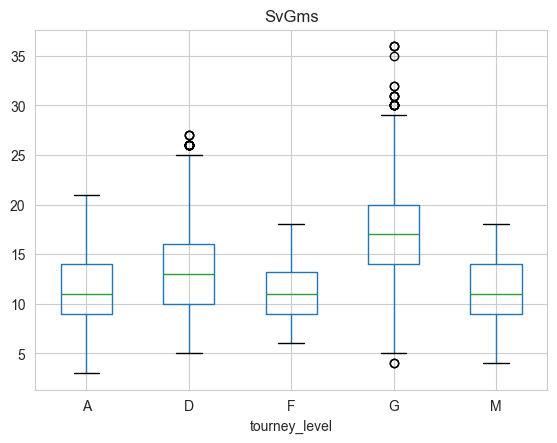

<Figure size 1000x600 with 0 Axes>

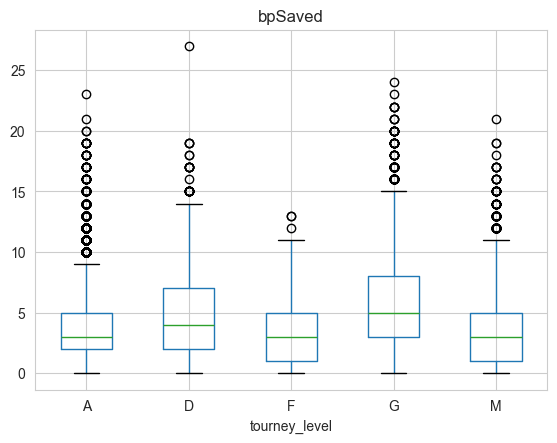

<Figure size 1000x600 with 0 Axes>

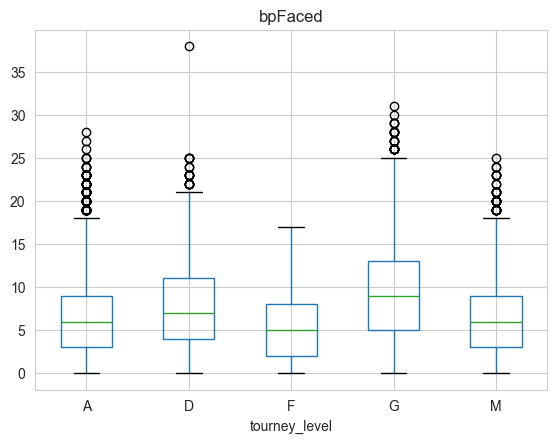

<Figure size 1000x600 with 0 Axes>

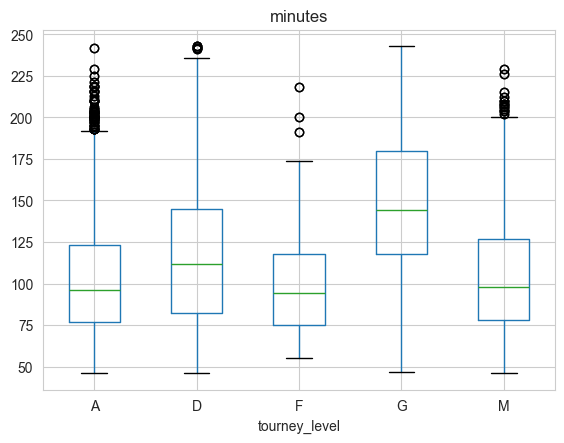

In [34]:
anova_results = {}

# Perform one-way ANOVA for each feature
for feature in combined_targets:
    a_data = df_anova[df_anova['tourney_level'] == 'A'][feature]
    g_data = df_anova[df_anova['tourney_level'] == 'G'][feature]
    m_data = df_anova[df_anova['tourney_level'] == 'M'][feature]
    f_data = df_anova[df_anova['tourney_level'] == 'F'][feature]
    d_data = df_anova[df_anova['tourney_level'] == 'D'][feature]

    f_statistic, p_value = stats.f_oneway(a_data, g_data, m_data, f_data, d_data)

    anova_results[feature] = {
        'F-statistic': f_statistic,
        'p-value': p_value,
        'Significant': p_value < 0.001
    }

results_df = pd.DataFrame.from_dict(anova_results, orient='index')
results_df = results_df.sort_values('p-value')

print("ANOVA Analysis Results:")
print(results_df)

# Visualize significant differences
significant_features = results_df[results_df['Significant']].index.tolist()
if significant_features:
    print("\nFeatures with statistically significant differences across surfaces:")
    for feature in significant_features:
        plt.figure(figsize=(10,6))
        df_anova.boxplot(column=feature, by='tourney_level')
        plt.title(f'{feature}')
        plt.suptitle('')
        plt.show()

#### Human features

In [35]:
df_human = pd.concat(
    (pd.DataFrame({'id': df_atp['winner_id'],
                   'ht': df_atp['winner_ht'],
                   'age': df_atp['winner_age'],
                   'tourney_level': df_atp['tourney_level']}),
     pd.DataFrame({'id': df_atp['loser_id'],
                   'ht': df_atp['loser_ht'],
                   'age': df_atp['loser_age'],
                   'tourney_level': df_atp['tourney_level']}),)
).groupby(by=['id', 'tourney_level'], dropna=True).mean()
df_human.reset_index(inplace=True)

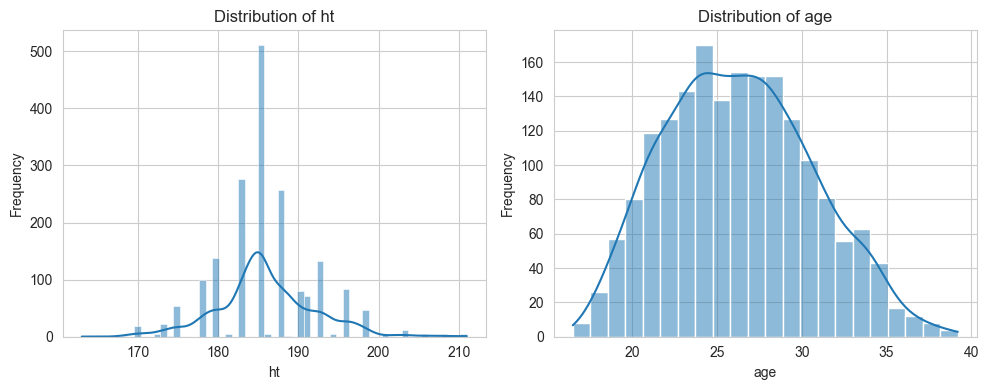

In [36]:
n_cols = 2
n_rows = 1
plt.figure(figsize=(10, 4))

# Plot distribution for each target column
for i, col in enumerate(['ht', 'age'], 1):
    plt.subplot(n_rows, n_cols, i)

    sns.histplot(df_human[col], kde=True)

    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [37]:
anova_results = {}

# Perform one-way ANOVA for each feature
for feature in ['ht', 'age']:
    g_data = df_human[df_human['tourney_level'] == 'G'][feature]
    a_data = df_human[df_human['tourney_level'] == 'A'][feature]
    m_data = df_human[df_human['tourney_level'] == 'M'][feature]
    d_data = df_human[df_human['tourney_level'] == 'D'][feature]
    f_data = df_human[df_human['tourney_level'] == 'F'][feature]

    f_statistic, p_value = stats.f_oneway(a_data, g_data, m_data, f_data, d_data)

    anova_results[feature] = {
        'F-statistic': f_statistic,
        'p-value': p_value,
        'Significant': p_value < 0.001
    }

results_df = pd.DataFrame.from_dict(anova_results, orient='index')
results_df = results_df.sort_values('p-value')

print("ANOVA Analysis Results:")
print(results_df)

ANOVA Analysis Results:
     F-statistic       p-value  Significant
age     8.853905  4.436456e-07         True
ht      2.764269  2.623002e-02        False


<Figure size 1000x600 with 0 Axes>

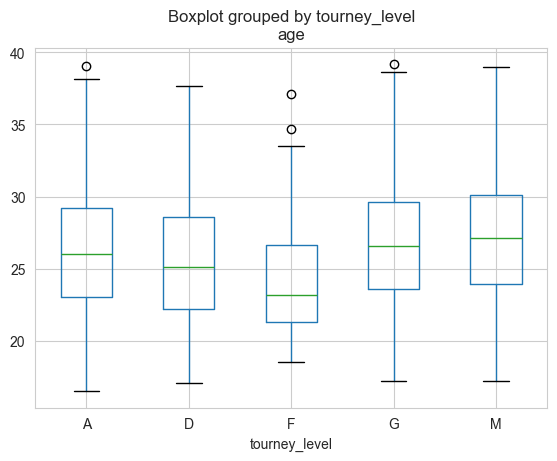

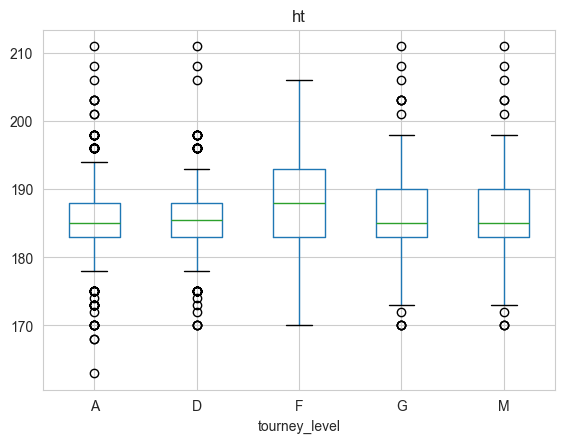

In [38]:
plt.figure(figsize=(10,6))
df_human.boxplot(column='age', by='tourney_level')
df_human.boxplot(column='ht', by='tourney_level')
plt.suptitle('')
plt.show()

### Model for predicting surface

ANOVA test showed that all these features are suitable for targeting surface.

In [39]:
combined_targets

['ace',
 'df',
 'svpt',
 '1stIn',
 '1stWon',
 '2ndWon',
 'SvGms',
 'bpSaved',
 'bpFaced',
 'minutes']

In [40]:
X = df_anova[combined_targets]
y = df_anova['surface']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [41]:
# Train the Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=24)
gb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = gb_classifier.predict(X_test)

In [42]:
# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

        Clay       0.57      0.25      0.35      2668
       Grass       0.46      0.03      0.06       852
        Hard       0.61      0.90      0.73      4795

    accuracy                           0.60      8315
   macro avg       0.55      0.40      0.38      8315
weighted avg       0.58      0.60      0.54      8315


Confusion Matrix:
[[ 675   10 1983]
 [  59   28  765]
 [ 452   23 4320]]


Model is weak. Shows that there is almost no difference between classes.

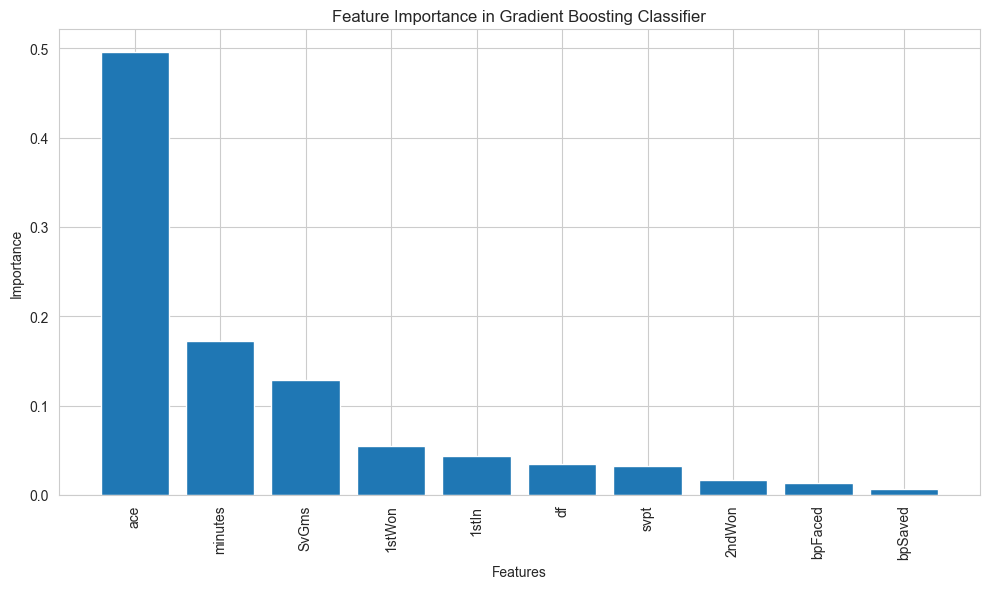

In [43]:
# Feature Importance
feature_importance = gb_classifier.feature_importances_
feature_importance_dict = dict(zip(combined_targets, feature_importance))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), [imp for _, imp in sorted_features])
plt.xticks(range(len(feature_importance)), [feat for feat, _ in sorted_features], rotation=90)
plt.title('Feature Importance in Gradient Boosting Classifier')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

### Model for predicting tourney level

ANOVA showed that all previous features are suitable for separating tourney level.

In [44]:
y = df_anova['tourney_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [45]:
gb_classifier.fit(X_train, y_train)
y_pred = gb_classifier.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

           A       0.64      0.98      0.77      4758
           D       0.00      0.00      0.00       338
           F       0.00      0.00      0.00        57
           G       0.82      0.52      0.64      1488
           M       0.55      0.00      0.01      1674

    accuracy                           0.66      8315
   macro avg       0.40      0.30      0.28      8315
weighted avg       0.62      0.66      0.56      8315


Confusion Matrix:
[[4680    0    2   72    4]
 [ 253    0    1   84    0]
 [  57    0    0    0    0]
 [ 706    0    2  779    1]
 [1649    0    0   19    6]]


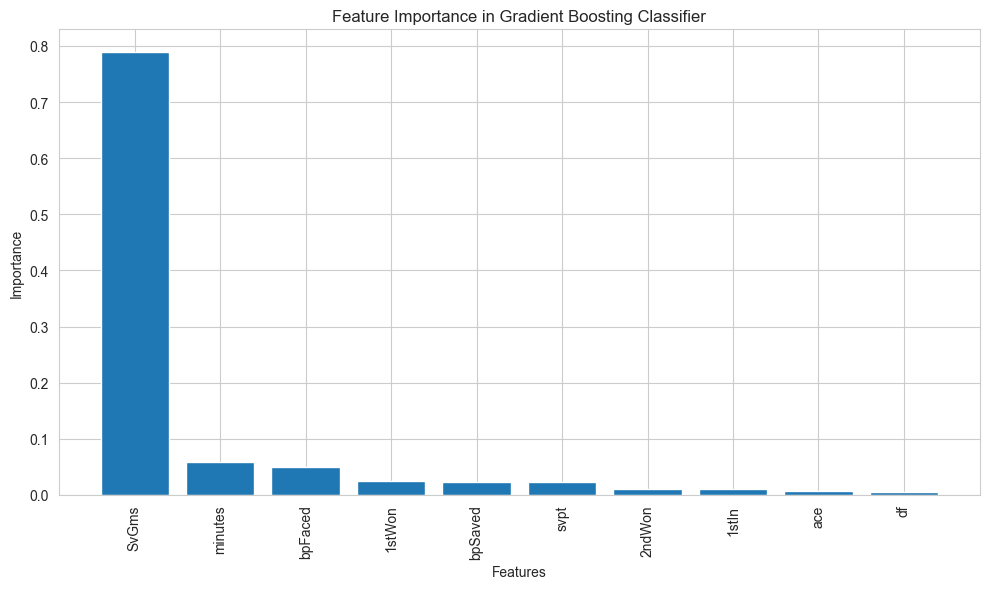

In [46]:
# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature Importance
feature_importance = gb_classifier.feature_importances_
feature_importance_dict = dict(zip(combined_targets, feature_importance))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), [imp for _, imp in sorted_features])
plt.xticks(range(len(feature_importance)), [feat for feat, _ in sorted_features], rotation=90)
plt.title('Feature Importance in Gradient Boosting Classifier')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

Same, poor model, predict the dominant class.